# CID distribution over the hash space

This script allows to visualize how homogeneous is the CID distribution in the SHA256 Hash space.

The distributions are calculated using the Normalized SHA256 Hash space, which means that instead of having the values from [0, (2^256)-1], values go from [0, 1].

In [1]:
## Import dependencies 
import sqlalchemy as sa
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Dependencies to manipulate CIDs
import multihash as mh
import cid 

## DB Credentials
HOST="localhost"
PORT="5432"
DB="hoarder_test"
USER="hoarder"
PASSWD="password"

# Connecte with the DB
engine = sa.create_engine(f'postgresql://{USER}:{PASSWD}@{HOST}:{PORT}/{DB}')

In [3]:
## Obtain the whole list of CIDs and get their normalized distribution in the hash space 

cids = pd.read_sql_query("""
SELECT cid_hash from cid_info;
""", engine)

# get multihash from the CID b58 string()
cids['multihash'] = cids.apply(lambda row: cid.make_cid(row['cid_hash']).multihash ,axis=1)

# get the int of the multihash.hash()
cids['hash_int'] = cids.apply(lambda row: int.from_bytes( mh.decode(row['multihash']).digest, byteorder="big") ,axis=1)

sha256 = (2 ** 256) -1
# normalize multihash.hash() in int in sha256 space
cids['hash_int_norm'] = cids.apply(lambda row: row['hash_int'] / sha256 ,axis=1)

ordered_cids = cids.sort_values('hash_int_norm')

Text(0, 0.5, 'CIDs')

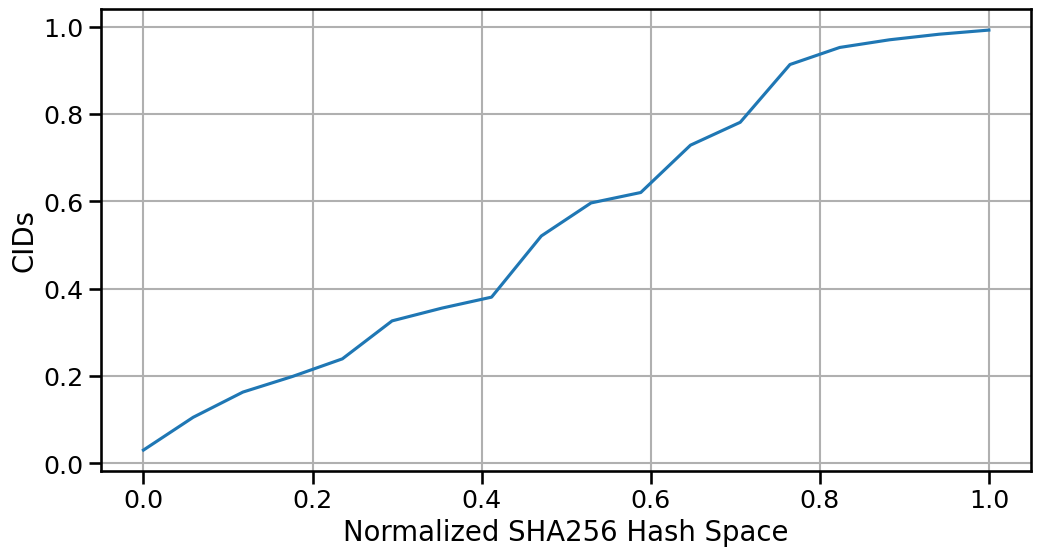

In [7]:
## plot the CDF distribution
 
sns.set_context("talk", font_scale=1.1)
plt.figure(figsize=(12,6))

sns.lineplot(y=ordered_cids['hash_int_norm'], x=np.linspace(0, 1, len(ordered_cids['hash_int_norm'])))
plt.grid(axis='both')
plt.xlabel('Normalized SHA256 Hash Space')
plt.ylabel('CIDs')



0.0703125


(-0.05, 1.1)

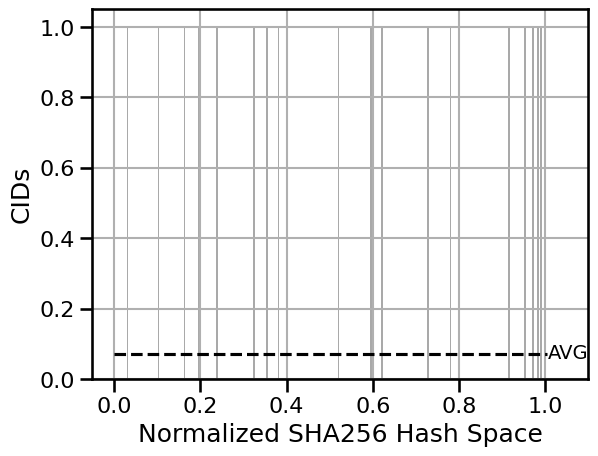

In [5]:
## plot the PFD distribution

BINS = 256 # KBUCKETs

bins = plt.hist(ordered_cids['hash_int_norm'], color='darkgrey', bins=BINS)

plt.grid()
plt.xlabel('Normalized SHA256 Hash Space', fontsize=18)
plt.ylabel('CIDs', fontsize=18)

mean = np.mean(bins[0])
maxi = max(bins[0])
mini = min(bins[0])

print(mean)

plt.hlines(y=[mean], xmin=0, xmax=1.005, color='black', linestyle='--', label='50%')
plt.text(1.006, mean+0.005, 'AVG', ha='left', va='center', color='black', fontsize=14)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='major', labelsize=16)
plt.xlim(-0.05, 1.1)


In [9]:
## Close the connection with the DB 

engine.dispose()